# MOwNiT 
## Laboratorium 1 - Arytmetyka komputerowa

Kalkulatory IEEE-754:
* http://babbage.cs.qc.cuny.edu/IEEE-754/
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

In [1]:
# znak, cecha, mantysa
# uwaga - w Julii tablice indeksujemy od 1
# uwaga: ukryta jedynka nie jest pamiętana
# uwaga: cecha jest pamiętana w kodzie z nadmiarem (tutaj BIAS=127)
decode(x::Float32) = (b=bitstring(x); (b[1], b[2:9], b[10:32]))

decode (generic function with 1 method)

## Trochę teorii IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - zawsze pierwszy bit ma wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [2]:
decode(Float32(2.5))

('0', "10000000", "01000000000000000000000")

In [3]:
cecha = 2^7-127
mantysa = 2^-2 + 1
cecha, mantysa

(1, 1.25)

In [4]:
L = 1 * mantysa * 2^cecha

2.5

### Liczba 0

Jeżeli zarówno mantysa jak i cecha zawierają same 0, to liczba reprezentuje wartość 0.

Ze względu na bit znaku, istnieją dwie reprezentacje 0: +0 oraz -0.

In [5]:
decode(Float32(-0.0))

('1', "00000000", "00000000000000000000000")

In [6]:
decode(Float32(+0.0))

('0', "00000000", "00000000000000000000000")

In [7]:
Float32(-0.0) == Float32(0.0)

true

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie ma "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: 0 nie jest zdenormalizowane, pomimo, że jego cecha ma same 0!

In [8]:
L = Float32(1e-42)
decode(Float32(L)), issubnormal(L)

(('0', "00000000", "00000000000001011001010"), true)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z 1 i mantysę z 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [9]:
decode(Inf32)

('0', "11111111", "00000000000000000000000")

In [10]:
decode(-Inf32)

('1', "11111111", "00000000000000000000000")

#### NaN

Reprezentowana jest przez cechę z 1 i mantysę różną od 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

NaNami są np 0/0, $\infty - \infty$

In [11]:
Float32(0)/Float32(0)

NaN32

In [12]:
Inf32 - Inf32

NaN32

In [13]:
decode(NaN32)

('0', "11111111", "10000000000000000000000")

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [14]:
e = eps(Float32)/2

5.9604645f-8

In [15]:
(Float32(1.0) + e) + e 

1.0f0

In [16]:
Float32(1.0) + (e + e)

1.0000001f0

Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie.

In [17]:
0.1 + 0.2 == 0.3 

false

In [18]:
isapprox(0.1 + 0.2, 0.3)

true

## Przykłady

In [19]:
bitstring(Float32(.1))

"00111101110011001100110011001101"

In [20]:
bitstring(Float32(1.0))

"00111111100000000000000000000000"

In [21]:
bitstring(Float64(1.0))

"0011111111110000000000000000000000000000000000000000000000000000"

In [22]:
# domyślnie Float64
bitstring(1.0)

"0011111111110000000000000000000000000000000000000000000000000000"

In [23]:
# Float16
bitstring(Float16(1.0))

"0011110000000000"

In [24]:
println(significand(Float32(1.2)), "*2^", exponent(Float32(1.20)))

1.2*2^0


In [25]:
# co ile liczby sa reprezentowane 
c=Float32[]
a=Float32(1.0)
r=1:10
for i=r
    push!(c, a)
    a=nextfloat(a)
end
map(x-> bitstring(x),c)

10-element Array{String,1}:
 "00111111100000000000000000000000"
 "00111111100000000000000000000001"
 "00111111100000000000000000000010"
 "00111111100000000000000000000011"
 "00111111100000000000000000000100"
 "00111111100000000000000000000101"
 "00111111100000000000000000000110"
 "00111111100000000000000000000111"
 "00111111100000000000000000001000"
 "00111111100000000000000000001001"

In [26]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
eps(Float32(1))

1.1920929f-7

In [27]:
eps(Float32(4))

4.7683716f-7

In [28]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = Float32(1e-33)
while a > 0
    a = a/Float32(2.0)
    println(a, decode(a), "  ", issubnormal(a))
end

5.0e-34('0', "00010000", "01001100010011101001100")  false
2.5e-34('0', "00001111", "01001100010011101001100")  false
1.25e-34('0', "00001110", "01001100010011101001100")  false
6.25e-35('0', "00001101", "01001100010011101001100")  false
3.125e-35('0', "00001100", "01001100010011101001100")  false
1.5625e-35('0', "00001011", "01001100010011101001100")  false
7.8125e-36('0', "00001010", "01001100010011101001100")  false
3.90625e-36('0', "00001001", "01001100010011101001100")  false
1.953125e-36('0', "00001000", "01001100010011101001100")  false
9.765625e-37('0', "00000111", "01001100010011101001100")  false
4.8828126e-37('0', "00000110", "01001100010011101001100")  false
2.4414063e-37('0', "00000101", "01001100010011101001100")  false
1.2207032e-37('0', "00000100", "01001100010011101001100")  false
6.103516e-38('0', "00000011", "01001100010011101001100")  false
3.051758e-38('0', "00000010", "01001100010011101001100")  false
1.525879e-38('0', "00000001", "01001100010011101001100")  false

In [29]:
# Rysowanie wykresów
using Pkg
#Pkg.add("Plots")
# http://docs.juliaplots.org/latest/tutorial/
using Plots

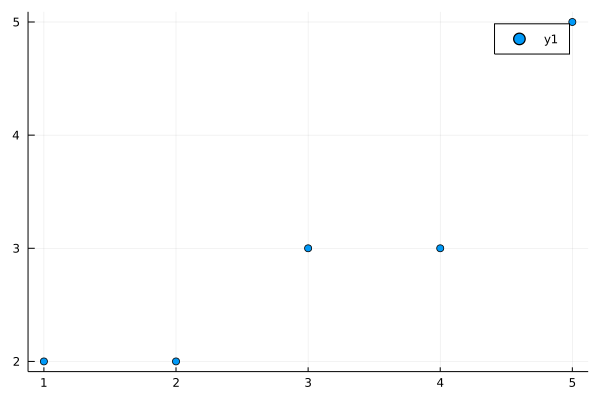

In [30]:
scatter(1:1:5, [2,2,3,3,5])

# Zadania

<b> Zadanie 1 </b>  Porównać w języku Julia reprezentację bitową liczby 1/3 dla Float16, Float32, Float64 oraz liczby, 
która jest inicjalizowana jako Float16, a potem rzutowana na Float64.

<b>Zadanie 2</b> Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

<b>Zadanie 3</b> Jedną z bibliotek numerycznych, jaką będziemy używać na zajęciach jest <a href="http://home.agh.edu.pl/~kzajac/dydakt/mownit/lab1/gsl.html">GSL</a> (język C). Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

<b>Zadanie 4</b> Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Julii.

## Zadanie 1

In [31]:
println(Float16(1/3)) #Reprezentacja 1/3 dla Float16
println(bitstring(Float16(1/3)))
println("------------------------------------------------")
println(Float32(1/3)) #Reprezentacja 1/3 dla Float32
println(bitstring(Float32(1/3)))
println("------------------------------------------------")
println(Float64(1/3))
println(bitstring(Float64(1/3))) #Reprezentacja 1/3 dla Float64
println("------------------------------------------------")
println(Float64(Float16(1/3)))
println(bitstring(Float64(Float16(1/3)))) #Reprezentacja 1/3 dla Float64 po wczesniejszym rzutowaniu na Float16

0.3333
0011010101010101
------------------------------------------------
0.33333334
00111110101010101010101010101011
------------------------------------------------
0.3333333333333333
0011111111010101010101010101010101010101010101010101010101010101
------------------------------------------------
0.333251953125
0011111111010101010101000000000000000000000000000000000000000000


## Zadanie 2

In [46]:
a = Float32(1e6)
A = [eps(Float32(a))]
X = [a]
println(a," ", decode(a))
while a > 1
    a = a/Float32(1.05) #W celu wyznaczenia kolejnych wartości otrzymaną wartość dzielimy jeszcze przez 2.
    push!(A, eps(Float32(a)))
    push!(X, a)
end

1.0e6 ('0', "10010010", "11101000010010000000000")


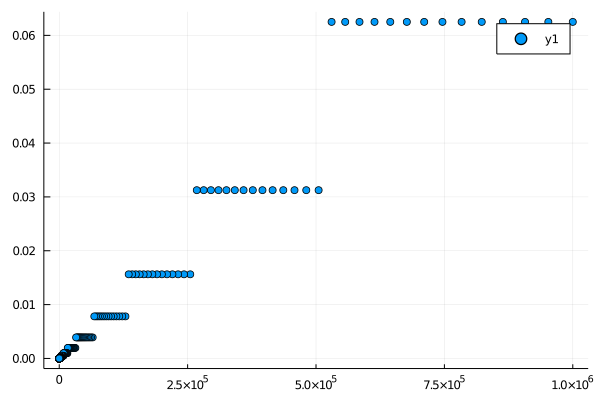

In [47]:
#println(A)
scatter(X,A)

Jak można zauważyć na wykresie, odstępy kolejnych wartości zmiennoprzecinkowych tworzą pewne poziomy, na których znajduje się stała liczba elementów (w powyższym przypadku 14). 
Im mniejsze liczby tym odstępy między poziomami maleją między sobą. Czyli jak widzimy im większa wartośc liczby, tym większe odstępy między liczbami co możemy również zobaczyć na wykresie. Im większe liczby tym lepiej widać ta różnicę wartości odstępu.

## Zadanie 3

### Pierwsza wersja

#include <stdio.h>
#include <gsl/gsl_math.h>
#include <gsl/gsl_ieee_utils.h>

int main(void)
{
    
    float x = 2e-33;
    
    while (x > 0){
        x = x / 2.0;
        printf(" x ="); gsl_ieee_printf_float(&x);
        printf("\n");
    }

    return 0;
}

### Wyniki   
   
    x = 1.01001100010011101001100*2^-110
    x = 1.01001100010011101001100*2^-111
    x = 1.01001100010011101001100*2^-112
    x = 1.01001100010011101001100*2^-113
    x = 1.01001100010011101001100*2^-114
    x = 1.01001100010011101001100*2^-115
    x = 1.01001100010011101001100*2^-116
    x = 1.01001100010011101001100*2^-117
    x = 1.01001100010011101001100*2^-118
    x = 1.01001100010011101001100*2^-119
    x = 1.01001100010011101001100*2^-120
    x = 1.01001100010011101001100*2^-121
    x = 1.01001100010011101001100*2^-122
    x = 1.01001100010011101001100*2^-123
    x = 1.01001100010011101001100*2^-124
    x = 1.01001100010011101001100*2^-125
    x = 1.01001100010011101001100*2^-126
    x = 0.10100110001001110100110*2^-126
    x = 0.01010011000100111010011*2^-126
    x = 0.00101001100010011101010*2^-126
    x = 0.00010100110001001110101*2^-126
    x = 0.00001010011000100111010*2^-126
    x = 0.00000101001100010011101*2^-126
    x = 0.00000010100110001001110*2^-126
    x = 0.00000001010011000100111*2^-126
    x = 0.00000000101001100010100*2^-126
    x = 0.00000000010100110001010*2^-126
    x = 0.00000000001010011000101*2^-126
    x = 0.00000000000101001100010*2^-126
    x = 0.00000000000010100110001*2^-126
    x = 0.00000000000001010011000*2^-126
    x = 0.00000000000000101001100*2^-126
    x = 0.00000000000000010100110*2^-126
    x = 0.00000000000000001010011*2^-126
    x = 0.00000000000000000101010*2^-126
    x = 0.00000000000000000010101*2^-126
    x = 0.00000000000000000001010*2^-126
    x = 0.00000000000000000000101*2^-126
    x = 0.00000000000000000000010*2^-126
    x = 0.00000000000000000000001*2^-126
    x = 0

### Druga wersja

#include <stdio.h>
#include <gsl/gsl_math.h>
#include <gsl/gsl_ieee_utils.h>

int main(void)
{

    float x = 1e-26;
    while (x > 0){
        x = x / 2.0;
        printf(" x ="); gsl_ieee_printf_float(&x);
        printf("\n");
    }

    return 0;
}

### Wyniki    
    
    x = 1.10001100001001000000110*2^-88
    x = 1.10001100001001000000110*2^-89
    x = 1.10001100001001000000110*2^-90
    x = 1.10001100001001000000110*2^-91
    x = 1.10001100001001000000110*2^-92
    x = 1.10001100001001000000110*2^-93
    x = 1.10001100001001000000110*2^-94
    x = 1.10001100001001000000110*2^-95
    x = 1.10001100001001000000110*2^-96
    x = 1.10001100001001000000110*2^-97
    x = 1.10001100001001000000110*2^-98
    x = 1.10001100001001000000110*2^-99
    x = 1.10001100001001000000110*2^-100
    x = 1.10001100001001000000110*2^-101
    x = 1.10001100001001000000110*2^-102
    x = 1.10001100001001000000110*2^-103
    x = 1.10001100001001000000110*2^-104
    x = 1.10001100001001000000110*2^-105
    x = 1.10001100001001000000110*2^-106
    x = 1.10001100001001000000110*2^-107
    x = 1.10001100001001000000110*2^-108
    x = 1.10001100001001000000110*2^-109
    x = 1.10001100001001000000110*2^-110
    x = 1.10001100001001000000110*2^-111
    x = 1.10001100001001000000110*2^-112
    x = 1.10001100001001000000110*2^-113
    x = 1.10001100001001000000110*2^-114
    x = 1.10001100001001000000110*2^-115
    x = 1.10001100001001000000110*2^-116
    x = 1.10001100001001000000110*2^-117
    x = 1.10001100001001000000110*2^-118
    x = 1.10001100001001000000110*2^-119
    x = 1.10001100001001000000110*2^-120
    x = 1.10001100001001000000110*2^-121
    x = 1.10001100001001000000110*2^-122
    x = 1.10001100001001000000110*2^-123
    x = 1.10001100001001000000110*2^-124
    x = 1.10001100001001000000110*2^-125
    x = 1.10001100001001000000110*2^-126
    x = 0.11000110000100100000011*2^-126
    x = 0.01100011000010010000010*2^-126
    x = 0.00110001100001001000001*2^-126
    x = 0.00011000110000100100000*2^-126
    x = 0.00001100011000010010000*2^-126
    x = 0.00000110001100001001000*2^-126
    x = 0.00000011000110000100100*2^-126
    x = 0.00000001100011000010010*2^-126
    x = 0.00000000110001100001001*2^-126
    x = 0.00000000011000110000100*2^-126
    x = 0.00000000001100011000010*2^-126
    x = 0.00000000000110001100001*2^-126
    x = 0.00000000000011000110000*2^-126
    x = 0.00000000000001100011000*2^-126
    x = 0.00000000000000110001100*2^-126
    x = 0.00000000000000011000110*2^-126
    x = 0.00000000000000001100011*2^-126
    x = 0.00000000000000000110010*2^-126
    x = 0.00000000000000000011001*2^-126
    x = 0.00000000000000000001100*2^-126
    x = 0.00000000000000000000110*2^-126
    x = 0.00000000000000000000011*2^-126
    x = 0.00000000000000000000010*2^-126
    x = 0.00000000000000000000001*2^-126
    x = 0

Mantysa przestaje być znormalizowana, gdy program dochodzi do takiego momentu, że cecha liczby wynosi -126 (Póki cecha jest większa od wartości -126 kolejne liczby zmiennoprzecinkowe posiadają zmniejszają cechę do momentu uzyskania wartości -126). Wtedy kolejne wartości zmiennoprzecinkowe nie posiadają mantysy znormalizowanej. Jest to spowodowane tym, że sama cecha ma również na swoje wartości i po osiągnięciu limitu wartości cechy program wykorzystuję operacje na mantysie w celu przedstawienia coraz to mniejszych liczb zmiennopozycyjnych.

## Zadanie 4

Wybranym algorytmem niestabilnym numerycznie jest algorytm wyliczania wartości wyrazu a(n) poprzez równanie rekurencyjne zadanie poniższym wzorem :

    a(n) = 1 - n*a(n-1)
    a(1) = 1/e  e - Liczba Eulera


#### Podpunk a)

Złe działanie algorytmu przejawia się tym, że dla pewnych wartości n wyraz a(n) osiąga wartości ujemne co jest błędne, ponieważ jeśli potraktujemy wyraz a(n) jako wartość całki na przedziale [0,1] z funkcji x^n * e^x-1, to jej wartość będzie określona rekurencyjnie i wynosiła 1 - n*a(n-1). 

Po wyliczeniu wartości a(18) na przykład na kartce papieru możemy zobaczyć, że wartość wyrazu a(18) jest dodatnia. Jednak wykorzystując algorytm niestabilny w celu wyliczenia wartości wyrazu osiągamy wartość ujemną co potwierdza fakt, że obecnie użyty algorytm jest niestabilny numerycznie.

In [108]:
recursiv(n) = n<=1 ? (1.0/exp(1)) : (1.0 - n*recursiv(n-1)) #Algorytm niestabilny numerycznie to wyliczenia wartości a(n)

recursiv (generic function with 1 method)

In [109]:
recursiv(18) # Ujemna wartość, a powinna być dodatnia. Akumulacja błędów spowodowała przekłamanie wyniku w znaczący sposób

-0.029453670751536265

#### Podpunk b)

Jedynym miejscem, które wpływa na akumulację błędów i zakłamywanie wyników jest miejsce wywoływania rekurencji n*recursiv(n-1)co powoduje występowanie catastrophic cancellation czyli między innymi odejmowanie bliskich liczb oraz ich normalizacja co powoduje dalsze problemy z wartościami mantysy.

#### Podpunkt C)

Algorytm stabilny wykorzystuje przekształenie wzoru:

    a(n) = 1 - n*a(n-1) 
    
    do postaci 
    
    a(n-1) = (1 - a(n))/n

Dodatkowo całkę po obszarze [0,1] określoną wzorem (x^n) * e^(x-1) można ograniczyć od góry wartością całki po obszarze [0,1] z funkcji x^n, której wartość to 1/(n+1). Zatem wyrażenie 1 - a(n) możemy zastąpić wyrażeniem 1/(n+1) powodując przy tym błąd równy 1/(n+1), który jest minimalizowany wraz z kolejnymi wartościami a(n).

Poniżej znajduje się wersja algorytmu stabilnego wysnaczania wartości a(n) oraz testowe wyznaczenie wartości a(18) w celu porównania wyników z algorytmem niestabilnym.

In [110]:
stablealgorigth(n) = 1/((n+1)*(n+2)) #Algorytm stabilny

stablealgorigth (generic function with 1 method)

In [111]:
stablealgorigth(18) #Wartość otrzymana dla algorytmu stabilnego. Jak widać, algorytm stabilny znacznie zminimalizował błędy obliczeń w porównianiu z algorytmem niestabilnym.

0.002631578947368421